In [22]:

# https://www.datos.gov.co/Salud-y-Protecci-n-Social/Clicsalud-Term-metro-de-Precios-de-Medicamentos/n4dj-8r7k/about_data

import re
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("Clicsalud_-_Term_metro_de_Precios_de_Medicamentos_20240609.csv")


In [23]:
# Eliminar valores nulos
print(len(df))
df = df.dropna()
print(len(df))

11874
11874


In [24]:
# Sacar columnas que se usaran
df_filtered = df[["principio_activo", "concentracion", "unidad_de_dispensacion", "fabricante", "unidad_base", "canal", "precio_por_tableta", "factoresprecio", "numerofactor"]]
print(df_filtered.head(2))

# Hacer formato de la columna precios

# Convertir todos los valores de precio_por_tableta a cadenas
df_filtered['precio_por_tableta_float'] = df_filtered['precio_por_tableta'].str.replace(',', '').astype(float)

print(df_filtered['precio_por_tableta_float'])

# Aplicar log a precio

df_filtered['log_precio_por_tableta'] = np.log1p(df_filtered['precio_por_tableta_float'])


#df_filtered.to_csv("test.csv")

  principio_activo           concentracion unidad_de_dispensacion fabricante  \
0  acido valproico  acido valproico 500 mg      Tableta o cápsula  Lafrancol   
1       fluoxetina        fluoxetina 20 mg      Tableta o cápsula     Genfar   

  unidad_base      canal precio_por_tableta factoresprecio  numerofactor  
0          mg  Comercial           3,490.33          Medio             2  
1          mg  Comercial             363.13          Medio             2  
0         3490.33
1          363.13
2        57433.33
3          365.08
4          533.81
           ...   
11869      879.92
11870    18240.50
11871    11705.00
11872    29246.00
11873      563.50
Name: precio_por_tableta_float, Length: 11874, dtype: float64


/tmp/ipykernel_311884/2964780539.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['precio_por_tableta_float'] = df_filtered['precio_por_tableta'].str.replace(',', '').astype(float)
/tmp/ipykernel_311884/2964780539.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['log_precio_por_tableta'] = np.log1p(df_filtered['precio_por_tableta_float'])


In [25]:
# necesito solo

# Function to extract concentrations
def extraer_concentraciones(texto):
    # Find all occurrences of a number followed by a unit (mg, mcg, g, ml)
    concentraciones = re.findall(r'\d+\.?\d*\s*(?:mg|mcg|g|ml)', texto)
    # Join the found concentrations with ' + ' if there are multiple
    return ' + '.join(concentraciones)

# Factores de conversión
conversion_factors = {
    'mg': 0.001,
    'mcg': 0.000001,
    'g': 1,
    'ml': 1,  # Asumiendo que ml puede ser tratado como g para soluciones acuosas
    'ui': None,  # UI necesita un factor específico basado en el compuesto
    'kbq': None  # kbq no es directamente convertible a gramos
}

# Función para extraer y convertir concentraciones a gramos
def extraer_y_convertir_concentraciones(texto, unidad_base):
    partes = texto.split(' + ')
    suma_total = 0.0
    for parte in partes:
        match = re.match(r'(\d+\.?\d*)\s*(mg|mcg|g|ml|ui|kbq)', parte)
        if match:
            valor = float(match.group(1))
            unidad = match.group(2)
            if unidad in conversion_factors and conversion_factors[unidad] is not None:
                # Convertir a gramos usando el factor de conversión
                valor_en_gramos = valor * conversion_factors[unidad]
                suma_total += valor_en_gramos
            else:
                # Manejar unidades no convertibles
                print(f"Unidad no convertible a gramos: {unidad} en {parte}")
    return suma_total

df_filtered['concentracion_filtrado'] = df_filtered['concentracion'].apply(extraer_concentraciones)

# Aplicar la función al DataFrame
df_filtered['concentracion_en_gramos'] = df_filtered.apply(
    lambda row: extraer_y_convertir_concentraciones(row['concentracion_filtrado'], row['unidad_base']), axis=1)

# Label Encoding for the 'medicine' column
label_encoder = LabelEncoder()
df_filtered['principio_activo_encoded'] = label_encoder.fit_transform(df_filtered['principio_activo'])
df_filtered['unidad_de_dispensacion_encoded'] = label_encoder.fit_transform(df_filtered['unidad_de_dispensacion'])
df_filtered['fabricante_encoded'] = label_encoder.fit_transform(df_filtered['fabricante'])
df_filtered['factoresprecio_encoded'] = label_encoder.fit_transform(df_filtered['factoresprecio'])
df_filtered['canal_encoded'] = label_encoder.fit_transform(df_filtered['canal'])


#df_filtered.to_csv("test.csv")

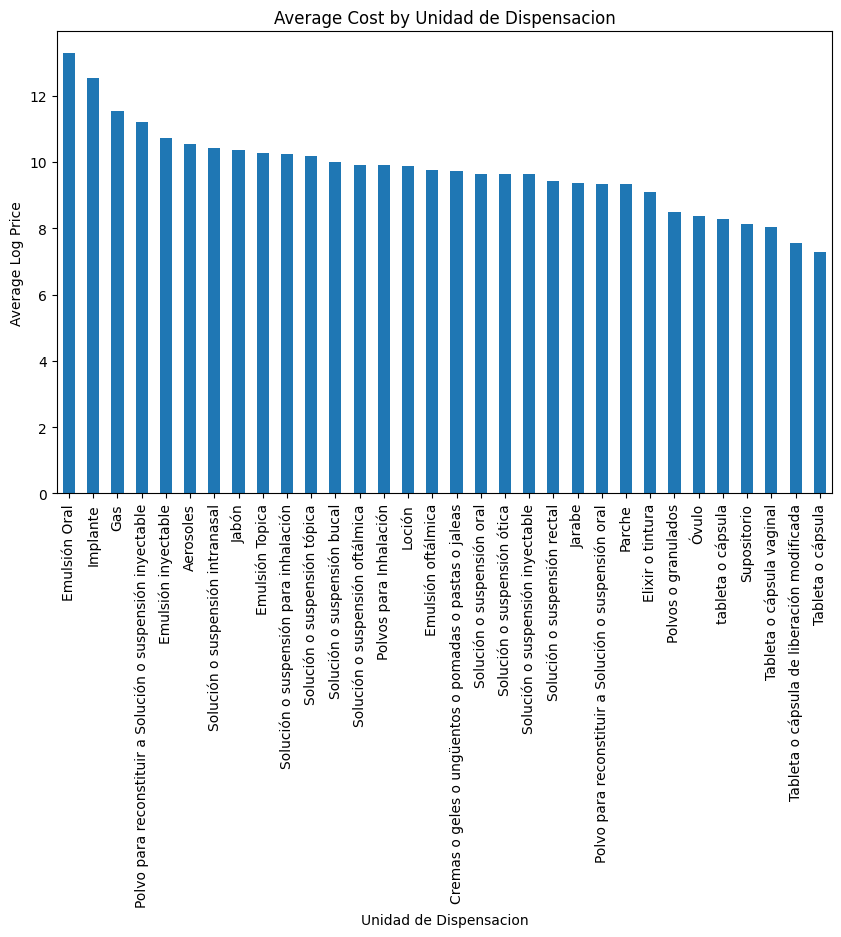

In [49]:
# Calculate the mean cost for each category
mean_cost_unidad = df_filtered.groupby('unidad_de_dispensacion')['log_precio_por_tableta'].mean().sort_values(ascending=False)

# Plot the average cost for each "unidad_de_dispensacion"
plt.figure(figsize=(10, 6))
mean_cost_unidad.plot(kind='bar')
plt.title('Average Cost by Unidad de Dispensacion')
plt.ylabel('Average Log Price')
plt.xlabel('Unidad de Dispensacion')

plt.savefig('AverageCostbyUnidaddeDispensacion.png', dpi=300, bbox_inches='tight')


plt.show()




In [27]:
# dividir entrenamiento y prueba
train_df, test_df = train_test_split(df_filtered, test_size=0.2, random_state=42)
# Normalización de precios

scaler = RobustScaler()

# Fit the scaler on the training data and transform it
train_df['precio_normalizado'] = scaler.fit_transform(train_df[['precio_por_tableta_float']])
test_df['precio_normalizado'] = scaler.fit_transform(test_df[['precio_por_tableta_float']])


train_df.to_csv("train_df.csv")

In [28]:
# comencemos con el primer experimento enfocado en predecir precios basándonos en la columna concentracion_en_gramos

# Tomamos una muestra aleatoria para visualizar la data
df_sample = train_df.sample(frac=0.1, random_state=42)

# Identify the top 20 most frequent compounds
top_20_compounds = df_sample['principio_activo'].value_counts().head(20).index

# Filter data to include only the top 20 compounds
data_filtered_20 = df_sample[df_sample['principio_activo'].isin(top_20_compounds)]

# Display the filtered data
print(data_filtered_20)



      principio_activo                         concentracion  \
389         ibuprofeno                       ibuprofeno 2 mg   
5384       diclofenaco                     diclofenaco 50 mg   
7125     oximetazolina                   oximetazolina 0,5 g   
3487        secnidazol                     secnidazol 500 mg   
10076    rosuvastatina                   rosuvastatina 10 mg   
...                ...                                   ...   
3816     oximetazolina                   oximetazolina 25 mg   
3390      azitromicina                   azitromicina 500 mg   
6396       clotrimazol                       clotrimazol 1 g   
3052        ibuprofeno  ibuprofeno 65 mg + ibuprofeno 200 mg   
4990      nitazoxanida                   nitazoxanida 500 mg   

                                  unidad_de_dispensacion  \
389                           Solución o suspensión oral   
5384          Tableta o cápsula de liberación modificada   
7125               Solución o suspensión para inhal

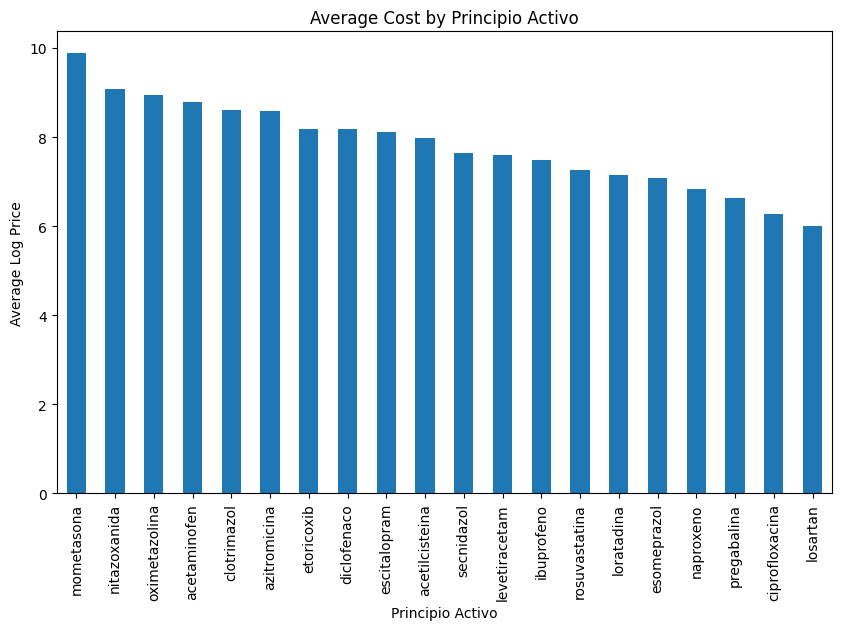

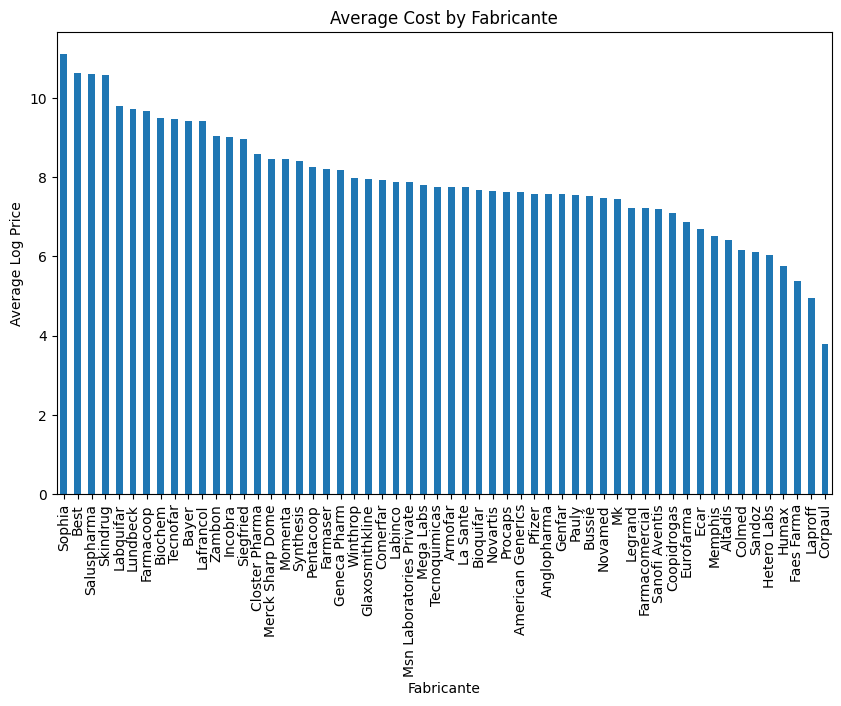

In [47]:

mean_cost_principio = data_filtered_20.groupby('principio_activo')['log_precio_por_tableta'].mean().sort_values(ascending=False)
mean_cost_fabricante = data_filtered_20.groupby('fabricante')['log_precio_por_tableta'].mean().sort_values(ascending=False)

# Plot the average cost for each "principio_activo"
plt.figure(figsize=(10, 6))
mean_cost_principio.plot(kind='bar')
plt.title('Average Cost by Principio Activo')
plt.ylabel('Average Log Price')
plt.xlabel('Principio Activo')

plt.savefig('AverageCostbyPrincipioActivo.png', dpi=300, bbox_inches='tight')

plt.show()




# Plot the average cost for each "fabricante"
plt.figure(figsize=(10, 6))
mean_cost_fabricante.plot(kind='bar')
plt.title('Average Cost by Fabricante')
plt.ylabel('Average Log Price')
plt.xlabel('Fabricante')

plt.savefig('AverageCostbyFabricante.png', dpi=300, bbox_inches='tight')

plt.show()



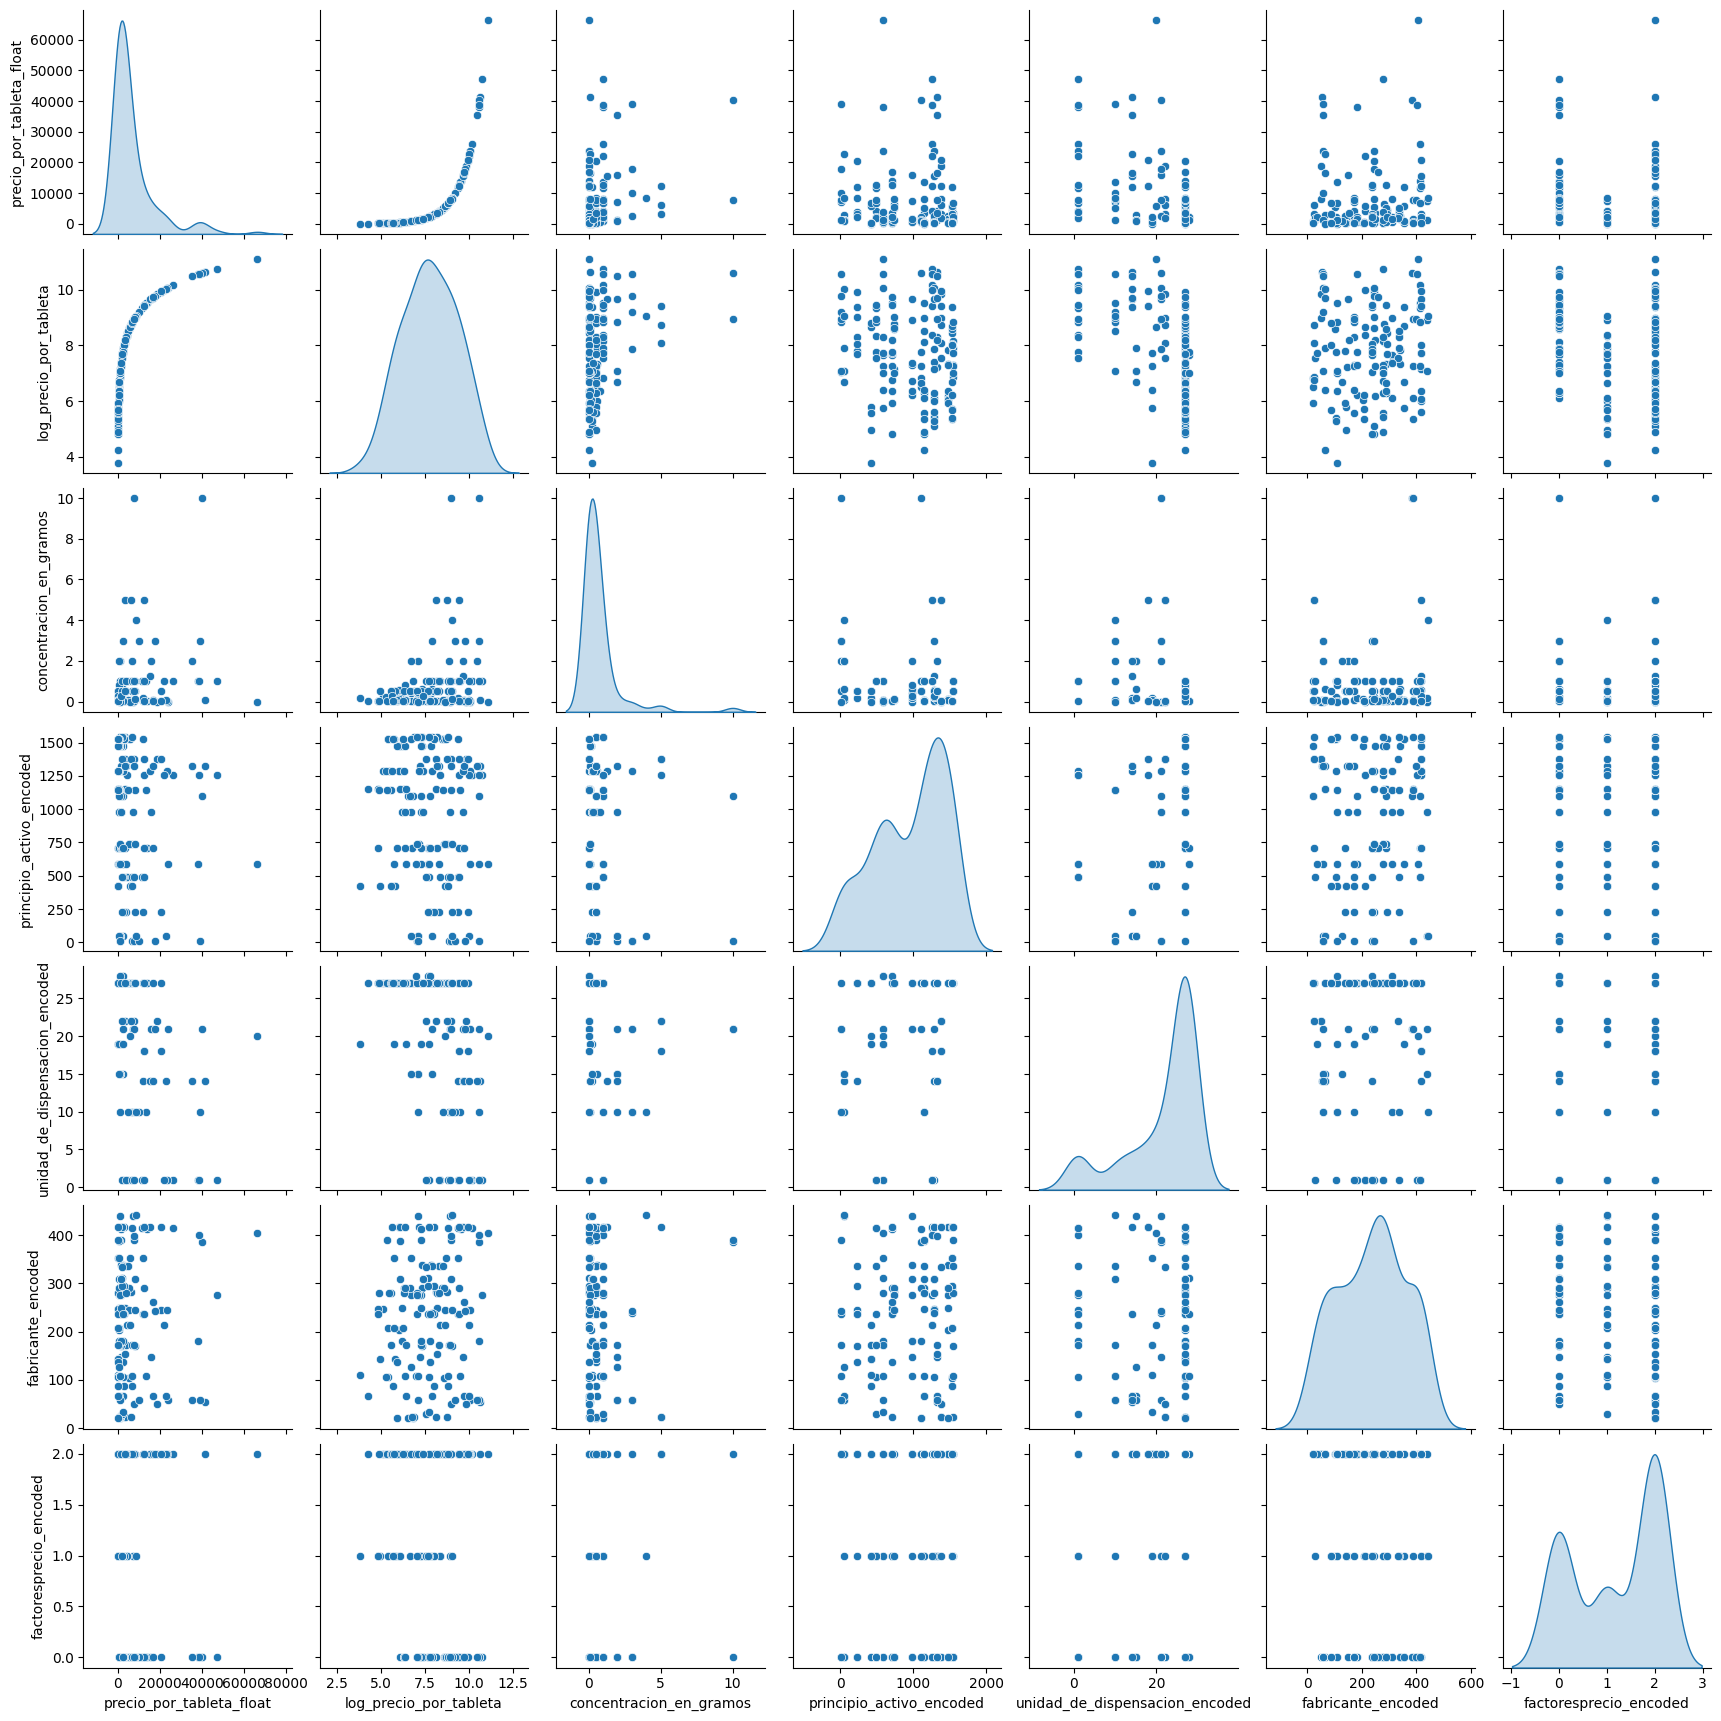

In [30]:
# Pairplot for comprehensive visualization
sns.pairplot(data_filtered_20, vars=['precio_por_tableta_float','log_precio_por_tableta', 'concentracion_en_gramos', 'principio_activo_encoded', 'unidad_de_dispensacion_encoded', 'fabricante_encoded', 'factoresprecio_encoded'], diag_kind='kde')
plt.show()


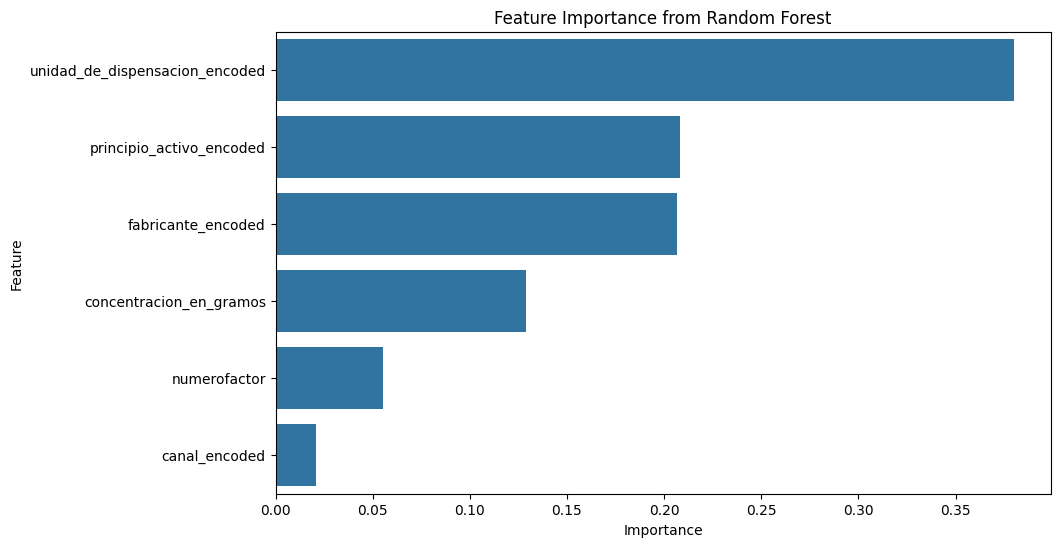

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# Prepare the data for Random Forest
X = df_filtered[['concentracion_en_gramos', 'principio_activo_encoded', 'unidad_de_dispensacion_encoded', 'fabricante_encoded', 'numerofactor', 'canal_encoded']]
y = df_filtered['log_precio_por_tableta']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance from Random Forest')

plt.savefig('Feature Importance from Random Forest.png', dpi=300, bbox_inches='tight')


plt.show()



In [32]:
# from sklearn.cluster import KMeans

# # Fit K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df_filtered['Cluster'] = kmeans.fit_predict(X)

# important_features = ['precio_por_tableta_float','log_precio_por_tableta', 'concentracion_en_gramos', 'principio_activo_encoded', 'unidad_de_dispensacion_encoded', 'fabricante_encoded', 'factoresprecio_encoded']

# # Pairplot with cluster labels
# sns.pairplot(df_filtered, vars=important_features, hue='Cluster', diag_kind='kde', palette='viridis')
# plt.show()

In [33]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Scatter plot of log_precio_por_tableta vs fabricante_encoded
# plt.figure(figsize=(12, 6))
# sns.scatterplot(data=df_filtered, x='principio_activo_encoded', y='log_precio_por_tableta', hue='Cluster', palette='viridis')
# plt.title('Scatter Plot of Log Price vs. Principio activo (Encoded)')
# plt.xlabel('Manufacturer (Encoded)')
# plt.ylabel('Log Price per Tablet')
# plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

In [34]:
# Apply log transformation to prices


# Boxplot of log-transformed prices by top 20 compounds
# plt.figure(figsize=(12, 6))
# sns.boxplot(x='principio_activo', y='log_precio_por_tableta', data=data_filtered)
# plt.title('Boxplot of Log-Transformed Prices by Top 20 Compounds')
# plt.xticks(rotation=90)
# plt.show()

In [35]:
# Apply log transformation to prices


# Boxplot of log-transformed prices by top 20 compounds
# plt.figure(figsize=(12, 6))
# sns.boxplot(x='unidad_de_dispensacion', y='log_precio_por_tableta', data=data_filtered)
# plt.title('Boxplot of Log-Transformed Prices by Top 20 Compounds')
# plt.xticks(rotation=90)
# plt.show()

/tmp/ipykernel_311884/1265097386.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster')


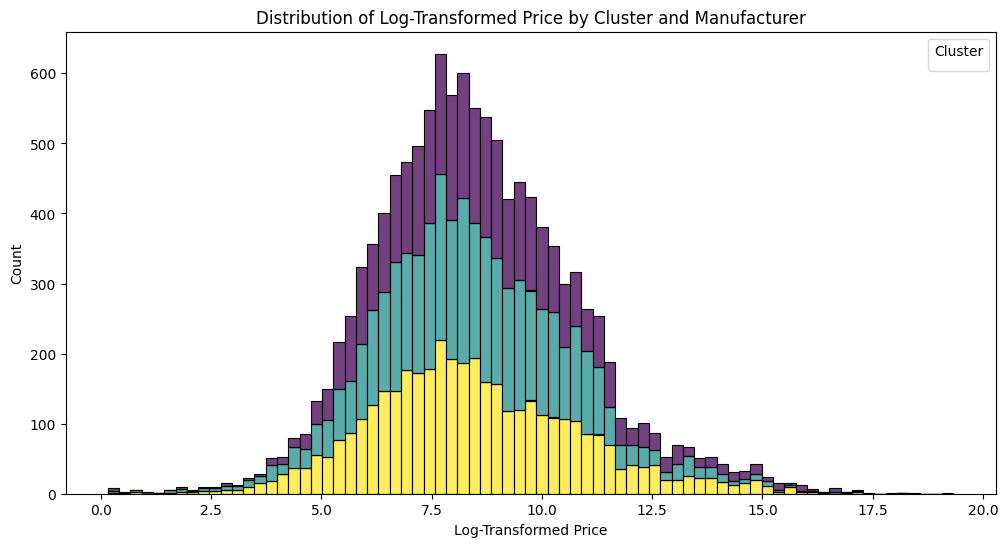

In [36]:
# # Group by cluster and calculate descriptive statistics
cluster_stats = df_filtered.groupby('Cluster').describe()
# print(cluster_stats)

# Group by cluster and calculate descriptive statistics for 'log_precio_por_tableta'
cluster_stats = df_filtered.groupby(['Cluster', 'fabricante_encoded'])['log_precio_por_tableta'].describe()
#print(cluster_stats)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution of 'log_precio_por_tableta' for each cluster by 'fabricante_encoded'
plt.figure(figsize=(12, 6))
sns.histplot(data=df_filtered, x='log_precio_por_tableta', hue='Cluster', multiple='stack', palette='viridis')
plt.title('Distribution of Log-Transformed Price by Cluster and Manufacturer')
plt.xlabel('Log-Transformed Price')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()



In [37]:
# Function to make a prediction for a new input
def visualize_model(history, ymin=None, ymax=None):
    # Lets visualize our model
    print(history.history.keys())
    # Lets plot the loss
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Number of epochs')
    plt.ylim([ymin,ymax]) # To zoom in on the y-axis
    plt.legend(['loss plot'], loc='upper right')
    plt.show()


In [38]:
# Select important features based on feature importance
important_features = ['unidad_de_dispensacion_encoded', 'principio_activo_encoded', 'fabricante_encoded', 'concentracion_en_gramos', 'numerofactor', 'canal_encoded']

# Prepare the data
X = train_df[important_features]
y = train_df['log_precio_por_tableta']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#########

model1 = LinearRegression()
model1.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model1.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Mean Squared Error: {mae}')
print(f'Mean Squared Error: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 1.4730845285260665
Mean Squared Error: 1.9474310622291187
Mean Squared Error: 3.7924877421348335
R^2 Score: 0.25809477107513823


Epoch 1/100


/home/flan/Documents/Coding/ProjectoPrecioMedicina/.env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 17728992778702028800.0000 - mae: 17728992778702028800.0000 
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7232 - mae: 5.7232
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5237 - mae: 3.5237
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1626 - mae: 2.1626
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8180 - mae: 1.8180
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7477 - mae: 1.7477
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7617 - mae: 1.7617
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7535 - mae: 1.7535  
Epoch 9/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7592 - mae: 1.7592
Epoch 10/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7479 - mae: 1.7479  
Epoch 11/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7217 - mae: 1.7217
Epoch 12/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7

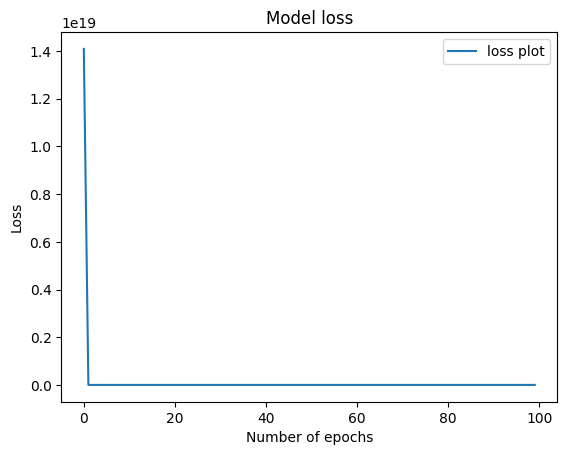

In [39]:
model_2 = Sequential([
    Dense(units=64, activation='relu',
          input_shape=[len(X_train.columns)]),
    Dense(units=64, activation="relu"),
    Dense(units=1)
])

model_2.compile(loss="mae", optimizer=tf.keras.optimizers.SGD(), metrics=['mae'])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    mode='min',          # Stop when the quantity monitored has stopped decreasing
    verbose=1            # Print a message when stopping
)



history_2 = model_2.fit(X_train, y_train, epochs=100)

# Make predictions on the test set
y_pred = model_2.predict(X_test)
y_pred = y_pred.flatten()  # Flatten the predictions to a 1D array

# Calculate the evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

visualize_model(history_2)

In [40]:
# # Define model_3
# model_3 = Sequential([
#     Dense(units=64, activation='relu', input_shape=[len(X_train.columns)]),
#     Dense(units=64, activation='relu'),
#     Dense(units=1)
# ])

# # Compile the model
# model_3.compile(loss='mae', optimizer='Adam', metrics=['mae'])

# # Define the early stopping callback
# early_stop = EarlyStopping(
#     monitor='val_loss',  # Monitor validation loss
#     patience=10,         # Number of epochs with no improvement after which training will be stopped
#     mode='min',          # Stop when the quantity monitored has stopped decreasing
#     verbose=1            # Print a message when stopping
# )

# # Train the model with early stopping
# history_3 = model_3.fit(
#     X_train, y_train,
#     epochs=1000,
#     validation_split=0.2,
#     callbacks=[early_stop]
# )

# # Make predictions on the test set
# y_pred = model_3.predict(X_test)
# y_pred = y_pred.flatten()  # Flatten the predictions to a 1D array

# # Calculate the evaluation metrics
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# # Print the evaluation metrics
# print(f'Mean Absolute Error: {mae}')
# print(f'Root Mean Squared Error: {rmse}')
# print(f'Mean Squared Error: {mse}')
# print(f'R^2 Score: {r2}')

# visualize_model(history_3)

Epoch 1/200


/home/flan/Documents/Coding/ProjectoPrecioMedicina/.env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.7626 - mae: 5.7626 - val_loss: 6.0711 - val_mae: 6.0711
Epoch 2/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8081 - mae: 3.8081 - val_loss: 3.7565 - val_mae: 3.7565
Epoch 3/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0453 - mae: 3.0453 - val_loss: 2.9679 - val_mae: 2.9679
Epoch 4/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9403 - mae: 2.9403 - val_loss: 2.5238 - val_mae: 2.5238
Epoch 5/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6253 - mae: 2.6253 - val_loss: 2.9661 - val_mae: 2.9661
Epoch 6/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6988 - mae: 2.6988 - val_loss: 2.7830 - val_mae: 2.7830
Epoch 7/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6274 - mae: 2.6274 - val_loss: 3.9889 - val_mae: 3.9889
Epoch 8/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6193 - mae: 2.6193 - val_loss: 2.4507 - val_mae: 2.4507
Epoch 9/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

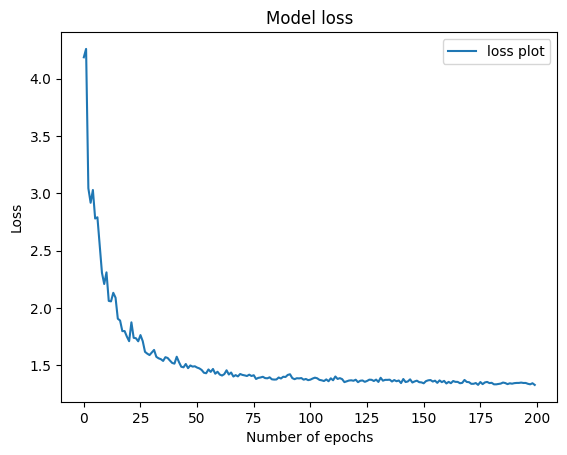

In [41]:
from tensorflow.keras.layers import Dense, Dropout

# Define model_4
model_4 = Sequential([
    Dense(units=64, activation='relu', input_shape=[len(X_train.columns)]),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

# Compile the model
model_4.compile(loss='mae', optimizer='Adam', metrics=['mae'])

# # Define the early stopping callback
# early_stop = EarlyStopping(
#     monitor='val_loss',  # Monitor validation loss
#     patience=20,         # Number of epochs with no improvement after which training will be stopped
#     mode='min',          # Stop when the quantity monitored has stopped decreasing
#     verbose=1            # Print a message when stopping
# )

# Train the model with early stopping
history_4 = model_4.fit(
    X_train, y_train,
    epochs=200,
    validation_split=0.2
)

# Make predictions on the test set
y_pred = model_4.predict(X_test)
y_pred = y_pred.flatten()  # Flatten the predictions to a 1D array

# Calculate the evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

visualize_model(history_4)

In [42]:
# # Define model_5
# model_5 = Sequential([
#     Dense(units=256, activation='relu', input_shape=[len(X_train.columns)]),
#     Dense(units=128, activation='relu'),
#     Dense(units=64, activation='relu'),
#     Dense(units=1)
# ])


# # Compile the model
# model_5.compile(loss='mae', optimizer='Adam', metrics=['mae'])

# # Define the early stopping callback
# early_stop = EarlyStopping(
#     monitor='val_loss',  # Monitor validation loss
#     patience=10,         # Number of epochs with no improvement after which training will be stopped
#     mode='min',          # Stop when the quantity monitored has stopped decreasing
#     verbose=1            # Print a message when stopping
# )

# # Train the model with early stopping
# history_5 = model_5.fit(
#     X_train, y_train,
#     epochs=1000,
#     validation_split=0.2,
#     callbacks=[early_stop]
# )

# # Make predictions on the test set
# y_pred = model_5.predict(X_test)
# y_pred = y_pred.flatten()  # Flatten the predictions to a 1D array

# # Calculate the evaluation metrics
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# # Print the evaluation metrics
# print(f'Mean Absolute Error: {mae}')
# print(f'Root Mean Squared Error: {rmse}')
# print(f'Mean Squared Error: {mse}')
# print(f'R^2 Score: {r2}')

# visualize_model(history_5)

In [43]:


#  Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f'{model_name} -> MAE: {mae}, RMSE: {rmse}, MSE: {mse}, R^2: {r2}')


model6 = RandomForestRegressor(n_estimators=100, random_state=42)

evaluate_model(model6, X_train, X_test, y_train, y_test, "Random Forest")

# Gradient Boosting Regressor (model7)
model7 = GradientBoostingRegressor(n_estimators=100, random_state=42)
evaluate_model(model7, X_train, X_test, y_train, y_test, "Gradient Boosting")

from xgboost import XGBRegressor

# XGBoost Regressor
model8 = XGBRegressor(n_estimators=100, random_state=42)
evaluate_model(model8, X_train, X_test, y_train, y_test, "XGBoost")

from lightgbm import LGBMRegressor

# LightGBM Regressor
model9 = LGBMRegressor(n_estimators=100, random_state=42)
evaluate_model(model9, X_train, X_test, y_train, y_test, "LightGBM")

from catboost import CatBoostRegressor

# CatBoost Regressor
model10 = CatBoostRegressor(n_estimators=100, random_state=42, verbose=0)
evaluate_model(model10, X_train, X_test, y_train, y_test, "CatBoost")

from sklearn.svm import SVR

# Support Vector Regressor
model11 = SVR(kernel='rbf')
evaluate_model(model11, X_train, X_test, y_train, y_test, "SVR")


Random Forest -> MAE: 0.9165121768537313, RMSE: 1.3329767826653982, MSE: 1.7768271031249963, R^2: 0.6524082849212325
Gradient Boosting -> MAE: 1.13910640572228, RMSE: 1.5616708067254068, MSE: 2.438815708578383, R^2: 0.5229067963816596
XGBoost -> MAE: 0.8782822931905809, RMSE: 1.2574392037542956, MSE: 1.5811533511382367, R^2: 0.6906869530760318
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 745
[LightGBM] [Info] Number of data points in the train set: 7599, number of used features: 6
[LightGBM] [Info] Start training from score 8.461089
LightGBM -> MAE: 0.957775389234283, RMSE: 1.3388224607728105, MSE: 1.7924455814697635, R^2: 0.6493529208595126
CatBoost -> MAE: 0.9918570196242512, RMSE: 1.3719049366635672, MSE: 1.8821231552418665, R^2: 0.6318097498797781
SVR -> MAE: 1.6848366080985104, RMSE: 2.203530575457924, MSE: 4.855546996977931, R^2: 0.0501

In [44]:
import joblib

# Save the trained Random Forest model
joblib.dump(model8, 'model.pkl')

# # Make predictions
# predictions = loaded_model.predict(new_data_poly)
# print(predictions)

['model.pkl']

In [45]:
import pandas as pd
import joblib

# Create mappings from the DataFrame
unidad_de_dispensacion_mapping = train_df[['unidad_de_dispensacion', 'unidad_de_dispensacion_encoded']].drop_duplicates().set_index('unidad_de_dispensacion')['unidad_de_dispensacion_encoded'].to_dict()
principio_activo_mapping = train_df[['principio_activo', 'principio_activo_encoded']].drop_duplicates().set_index('principio_activo')['principio_activo_encoded'].to_dict()
fabricante_mapping = train_df[['fabricante', 'fabricante_encoded']].drop_duplicates().set_index('fabricante')['fabricante_encoded'].to_dict()
canal_mapping = train_df[['canal', 'canal_encoded']].drop_duplicates().set_index('canal')['canal_encoded'].to_dict()

# Define the prediction function
def predict_entry(model, entry, unidad_de_dispensacion_mapping, principio_activo_mapping, fabricante_mapping, canal_mapping):
    """
    Predict the output for a given entry using the trained model.

    Parameters:
    - model: Trained model loaded from pickle
    - entry: Dictionary containing the input features with human-readable names
    - unidad_de_dispensacion_mapping: Mapping dictionary for unidad_de_dispensacion
    - principio_activo_mapping: Mapping dictionary for principio_activo
    - fabricante_mapping: Mapping dictionary for fabricante
    - canal_mapping: Mapping dictionary for canal

    Returns:
    - Prediction result from the model
    """
    try:
        # Map human-readable names to encoded values
        entry_encoded = {
            'unidad_de_dispensacion_encoded': unidad_de_dispensacion_mapping[entry['unidad_de_dispensacion']],
            'principio_activo_encoded': principio_activo_mapping[entry['principio_activo']],
            'fabricante_encoded': fabricante_mapping[entry['fabricante']],
            'concentracion_en_gramos': entry['concentracion_en_gramos'],
            'numerofactor': entry['numerofactor'],
            'canal_encoded': canal_mapping[entry['canal']]
        }
    except KeyError as e:
        raise ValueError(f"Mapping error: {e}. Please ensure all values are correctly mapped.")

    # Convert the encoded entry to a DataFrame
    entry_df = pd.DataFrame([entry_encoded])
    
    # Ensure the order of columns matches the training data
    entry_df = entry_df[['unidad_de_dispensacion_encoded', 'principio_activo_encoded', 'fabricante_encoded', 'concentracion_en_gramos', 'numerofactor', 'canal_encoded']]
    
    # Predict using the model
    prediction = model.predict(entry_df)
    
    return prediction[0]  # Assuming the model returns a list/array of predictions

# Load the model
loaded_model = joblib.load('./model.pkl')  # Replace with the actual path to your model

# Example entry to predict
example_entry = {
    'unidad_de_dispensacion': 'Jarabe',
    'principio_activo': 'acido valproico',
    'fabricante': 'Novamed',
    'concentracion_en_gramos': 5,
    'numerofactor': 3,
    'canal': 'Comercial'
}

# Create the mappings from the training data
unidad_de_dispensacion_mapping = train_df[['unidad_de_dispensacion', 'unidad_de_dispensacion_encoded']].drop_duplicates().set_index('unidad_de_dispensacion')['unidad_de_dispensacion_encoded'].to_dict()
principio_activo_mapping = train_df[['principio_activo', 'principio_activo_encoded']].drop_duplicates().set_index('principio_activo')['principio_activo_encoded'].to_dict()
fabricante_mapping = train_df[['fabricante', 'fabricante_encoded']].drop_duplicates().set_index('fabricante')['fabricante_encoded'].to_dict()
canal_mapping = train_df[['canal', 'canal_encoded']].drop_duplicates().set_index('canal')['canal_encoded'].to_dict()

# Predict using the example entry
result = predict_entry(loaded_model, example_entry, unidad_de_dispensacion_mapping, principio_activo_mapping, fabricante_mapping, canal_mapping)
real_price_prediction = np.expm1(result)  # Reverse the log transformation

print("Prediction:", real_price_prediction)


Prediction: 27378.93
